## Import required packages

In [1]:
import os
import math
import glob
import time
import cv2
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import tree

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
%matplotlib inline

## Utility Functions to convert color space and plot image

In [2]:
# Hold the color code name and opencv objects in a dict for easy conversion
colorCodeDict = {
    'RGB2GRAY' : cv2.COLOR_RGB2GRAY,
    'RGB2RGBA' : cv2.COLOR_RGB2RGBA,
    'RGB2BGR' : cv2.COLOR_RGB2BGR,
    'RGB2BGRA' : cv2.COLOR_RGB2BGRA,
    'RGB2HSV' : cv2.COLOR_RGB2HSV,
    'RGB2HLS' : cv2.COLOR_RGB2HLS,
    'RGB2LUV' : cv2.COLOR_RGB2LUV,
    'RGB2YUV' : cv2.COLOR_RGB2YUV,
    'RGB2YCrCb' : cv2.COLOR_RGB2YCrCb,
    
    'BGR2GRAY' : cv2.COLOR_BGR2GRAY,
    'BGR2BGRA' : cv2.COLOR_BGR2BGRA,
    'BGR2RGB' : cv2.COLOR_BGR2RGB,
    'BGR2RGBA' : cv2.COLOR_BGR2RGBA,
    'BGR2HSV' : cv2.COLOR_BGR2HSV,
    'BGR2HLS' : cv2.COLOR_BGR2HLS,
    'BGR2LUV' : cv2.COLOR_RGB2LUV,
    'BGR2YUV' : cv2.COLOR_RGB2YUV,
    'BGR2YCrCb' : cv2.COLOR_RGB2YCrCb
}

def convert_color(img , convCode='RGB2GRAY'):
    """
        return image converted to required colospace
    """
    return cv2.cvtColor(img, colorCodeDict[convCode]);

def plot_img(img, show_stages=False, label=""):
    """
        plot image
    """
    if show_stages:
        print("############################# "+ label +" ##################################")
        plt.imshow(img, cmap='gray')
        plt.show()

## Functions to extract different image features

In [3]:
def bin_spatial(img, size=(32, 32)):
    """
        Return the image color bins
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):
    """
        Return all channel histogram.
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

def get_hog_features(img, orient, pix_per_cell, cell_per_block,feature_vector=True):
    """
        Return a histogram of oriented gradients using skimage.
    """
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vector)

## Wrapper function to extract and combine different features

In [4]:
def extract_features(imgs, colorConv, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """
        Wrapper function to return a bag of features by combining different features extracted with above functions.
    """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images and extract features
    for file in imgs:
        image = mpimg.imread(file)
        feature_image = convert_color(image, colorConv)
        spatial_features = bin_spatial(feature_image)
        hist_features = color_hist(feature_image)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return features

## Functions to train and test different classifiers

In [5]:
def train_SVC(X_train, y_train):
    """
        Function to train an svm.
    """
    svc = svm.LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    return svc

def train_dtree(X_train, y_train):
    """
        Function to train a decision tree.
    """
    clf = tree.DecisionTreeClassifier()
    t=time.time()
    clf = clf.fit(X_train, y_train)
    t=time.time()
    print(round(t2-t, 2), 'Seconds to train dtree...')
    return clf

def test_classifier(svc, X_test, y_test):
    """
        Funtion to test the classifier.
    """
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    pred = svc.predict(X_test[0:n_predict])
    actual = y_test[0:n_predict]
    print('My SVC predicts: ', pred)
    print('For these',n_predict, 'labels: ', actual)
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

## Functions to remove duplicate detections and false positives

In [6]:
def add_heat(heatmap, bbox_list):
    """
        Iterate the windows with detected cars and enhance the once with highest detections.
    """
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    """
        Only keep the detections that have a minimum number of pixels.
    """
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    """
        Draw the boxes on the detected cars
    """
    for i in range(1, labels[1]+1):
        # Find pixels with each car label value
        nonzero = (labels[0] == i).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img


## Use the classifier to detect cars

In [7]:
def find_cars(img, colorConv, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    """
        This function takes in an image, extracts the features from a region of interest and
        runs the predictions on the features.
        Returns a list of co-ordinates where car is detected.
    """
    img = img.astype(np.float32)/255
    img_shape = img.shape
    # Crop the image to remove sky and car bonnet
    ystart = math.floor(img_shape[0]*.55)
    ystop = math.floor(img_shape[0]*.85)
    img = img[ystart:ystop,:,:]
    #plot_img(img_tosearch, True)
    img = convert_color(img, colorConv)
    # Define blocks and steps as above
    nxblocks = (img.shape[1] // pix_per_cell)-1
    nyblocks = (img.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # set the window size same as the test image size
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog_ch1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, feature_vector=False)
    hog_ch2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, feature_vector=False)
    hog_ch3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, feature_vector=False)
    on_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog_ch1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog_ch2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog_ch3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(img[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = bin_spatial(subimg)
            # Get histogram feature
            hist_features = color_hist(subimg)
            # add all features and Scale them
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            # make a prediction
            test_prediction = svc.predict(test_features)
            # Add to list of windows if car predicted
            if test_prediction == 1:
                xbox_left = np.int(xleft)
                ytop_draw = np.int(ytop)
                win_draw = np.int(window)
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return on_windows

## Set prameters to be used for training the classifier and predictions

In [8]:
colorConv = 'BGR2HSV'
hog_channel = "ALL"
orient = 9
pix_per_cell = 8
cell_per_block = 2
recent_heatmaps = deque(maxlen=10)

## Setup training and validation data

In [9]:
def setup_train_data(colorConv, orient, pix_per_cell, cell_per_block, hog_channel):
    """
        Setup data for classifier training. 
        Shuffle the data and split it in training and testing set.
    """
    cars = []
    images = glob.glob('/home/neeraj/work/sdcnd/CarND-Vehicle-Detection/vehicles/vehicles/**/*.png', recursive=True)
    for image in images:
        cars.append(image)
    
    images = glob.glob('/home/neeraj/work/sdcnd/CarND-Vehicle-Detection/non-vehicles/**/*.png', recursive=True)
    notcars = []
    for image in images:
        notcars.append(image)

    car_features = extract_features(cars, colorConv, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
    notcar_features = extract_features(notcars, colorConv, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y_train = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # shuffle the data
    #X_train, y_train = shuffle(scaled_X, y_train)
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_train, test_size=0.2, random_state=2)
    return X_train, X_test, y_train, y_test, X_scaler

print('Preparing training data...')
X_train, X_test, y_train, y_test, X_scaler = setup_train_data(colorConv, orient, 
                                                              pix_per_cell, cell_per_block, hog_channel)
print("Number of training examples =", len(X_train))
print("Number of testing examples =", len(X_test))

Preparing training data...
Number of training examples = 11947
Number of testing examples = 2987


## Train the classifier

In [10]:
print('Training Classifier...')
svc = train_SVC(X_train, y_train)
#clf = train_dtree(X_train, y_train)

Training Classifier...
7.07 Seconds to train SVC...


## Test the classifier

In [11]:
print('Testing Classifier...')
test_classifier(svc, X_test, y_test)
#test_classifier(clf, X_test, y_test)

Testing Classifier...
Test Accuracy of SVC =  0.9963
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  1.  0.  0.  1.]
0.00442 Seconds to predict 10 labels with SVC


## Wraper function to preprocess image run the classifier and post processing the result.

In [12]:
def process_img(img, threshhold=1.5, show_stages=False):
    """
        Wrapper function to perform all the processing.
    """
    
    # get the windows where the classifier predicts car
    hot_windows = find_cars(img, colorConv, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    if show_stages:
        img1 = np.copy(img)
        for bbox in hot_windows:
            cv2.rectangle(img1, bbox[0], bbox[1], (0,0,255), 6)
        plot_img(img1, show_stages, "All detections")
    
    # Highlight the windows
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    plot_img(heat, show_stages, "After Applying heat")
    
    # Append the detections to detections from last n frames
    recent_heatmaps.append(heat)
    
    # Take the mean of last n frames as discard the windows that are below the threshold
    heatmap = apply_threshold(np.mean(recent_heatmaps, axis=0),threshhold)
    plot_img(heatmap, show_stages, "After threshold")
    
    # Add labels to remaning detections
    labels = label(heatmap)
    # Draw boxes on the cars and return the image
    return draw_labeled_bboxes(np.copy(img), labels)

## Test on images


------------------------------test_images/test6.jpg---------------------------------
############################# All detections ##################################


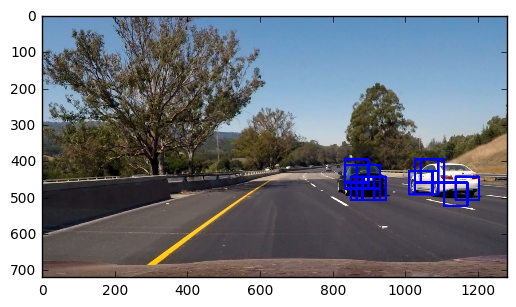

############################# After Applying heat ##################################


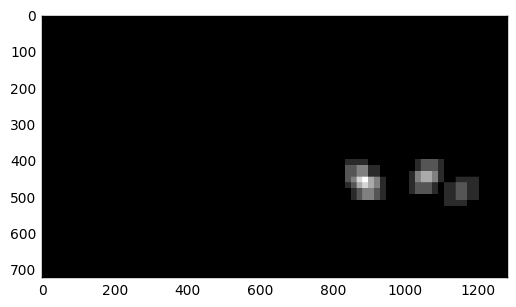

############################# After threshold ##################################


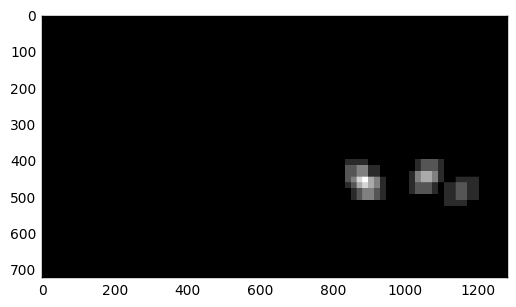

############################# Final Result ##################################


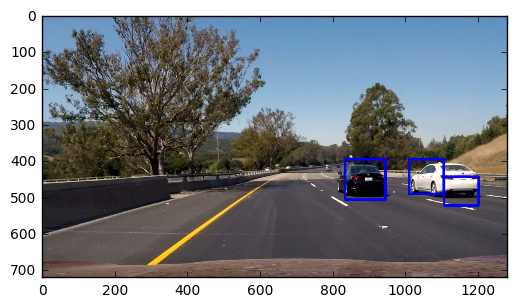



------------------------------test_images/test.jpg---------------------------------
############################# All detections ##################################


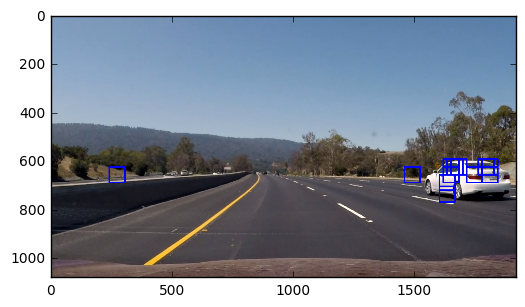

############################# After Applying heat ##################################


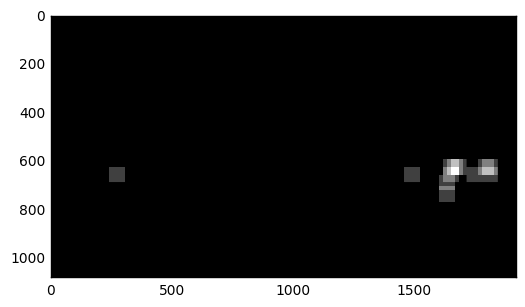

############################# After threshold ##################################


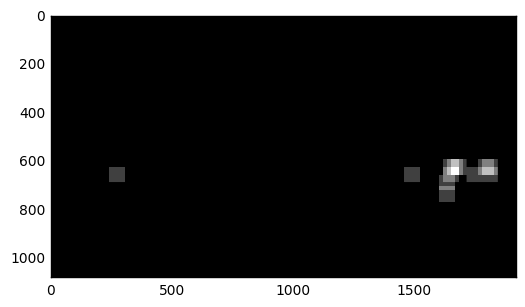

############################# Final Result ##################################


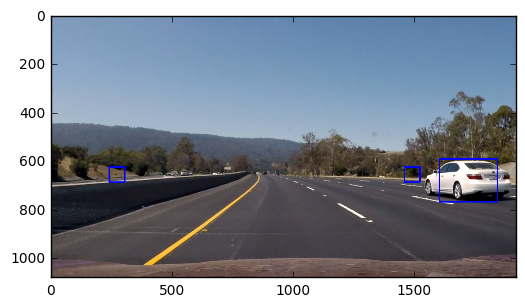



------------------------------test_images/test3.jpg---------------------------------
############################# All detections ##################################


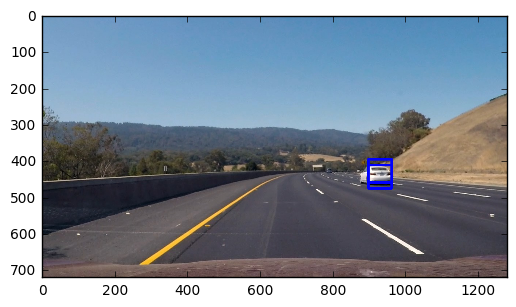

############################# After Applying heat ##################################


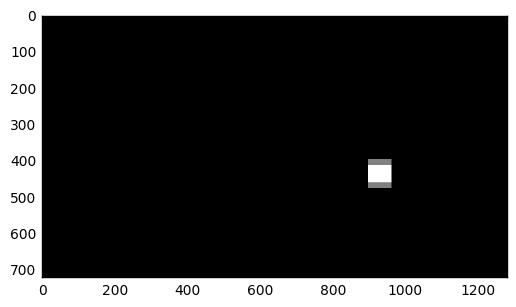

############################# After threshold ##################################


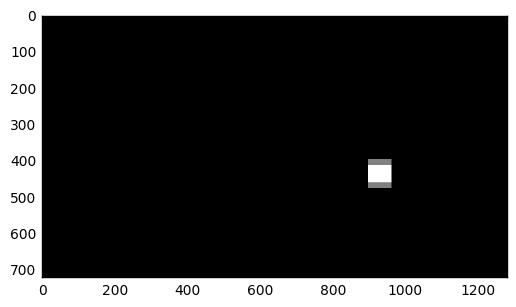

############################# Final Result ##################################


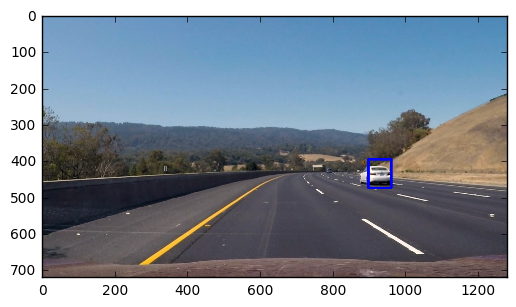



------------------------------test_images/test4.jpg---------------------------------
############################# All detections ##################################


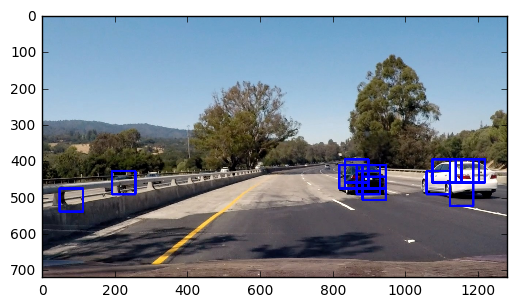

############################# After Applying heat ##################################


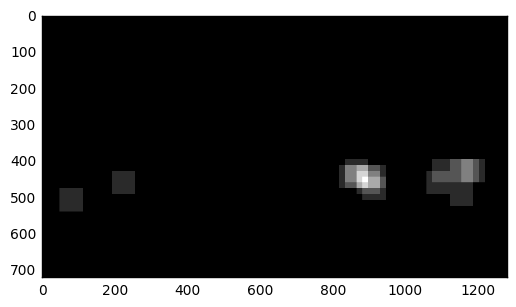

############################# After threshold ##################################


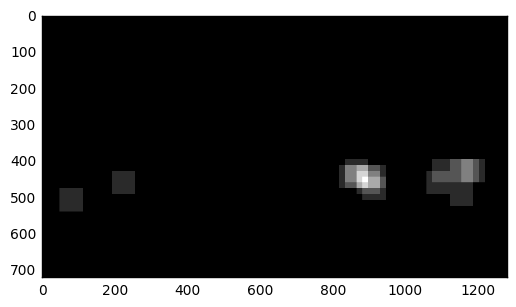

############################# Final Result ##################################


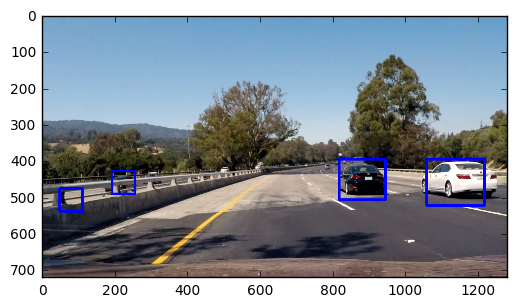



------------------------------test_images/test2.jpg---------------------------------
############################# All detections ##################################


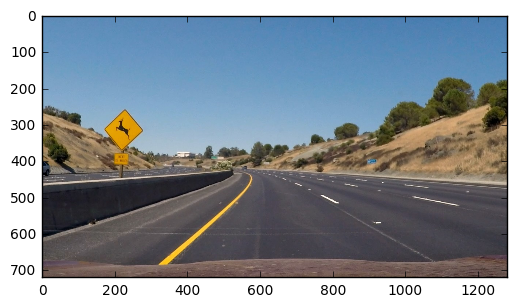

############################# After Applying heat ##################################


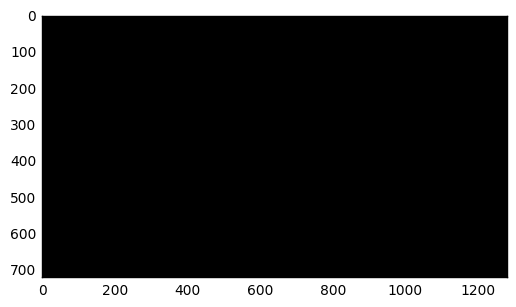

############################# After threshold ##################################


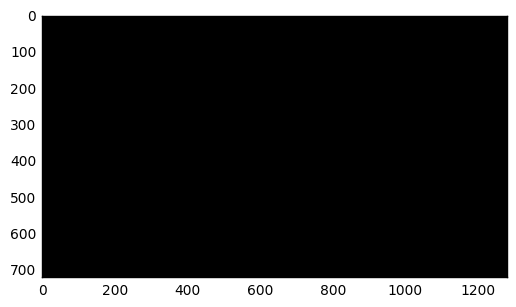

############################# Final Result ##################################


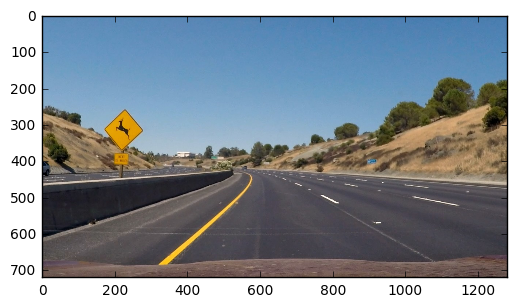



------------------------------test_images/test1.jpg---------------------------------
############################# All detections ##################################


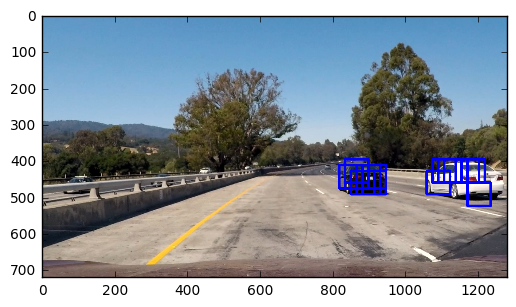

############################# After Applying heat ##################################


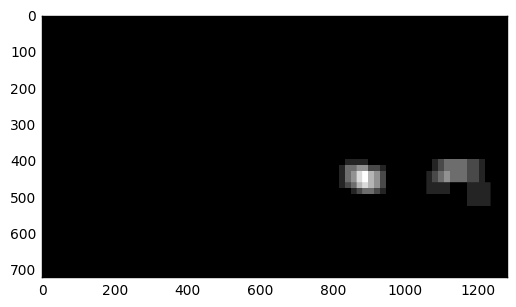

############################# After threshold ##################################


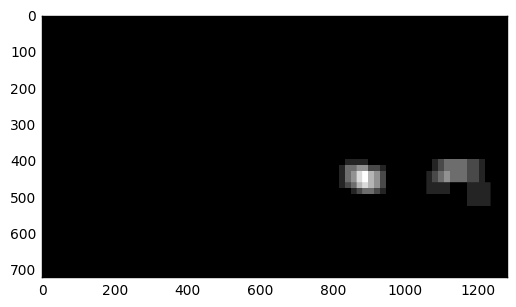

############################# Final Result ##################################


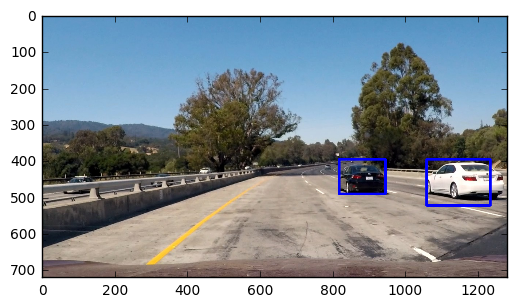



------------------------------test_images/test5.jpg---------------------------------
############################# All detections ##################################


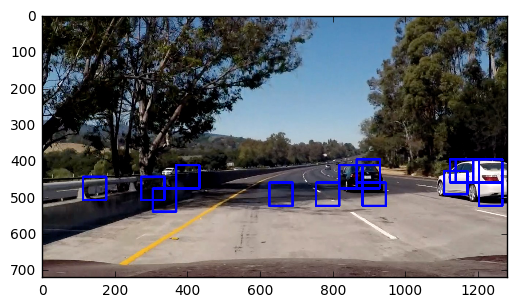

############################# After Applying heat ##################################


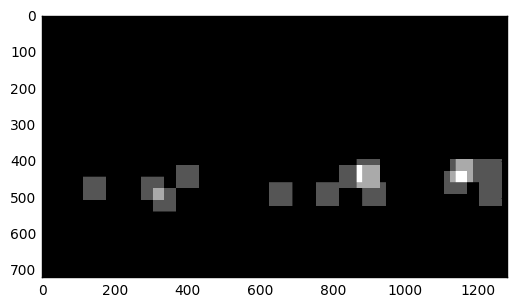

############################# After threshold ##################################


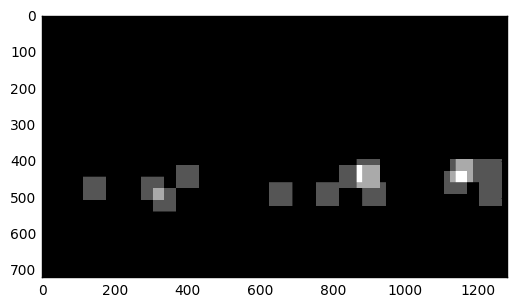

############################# Final Result ##################################


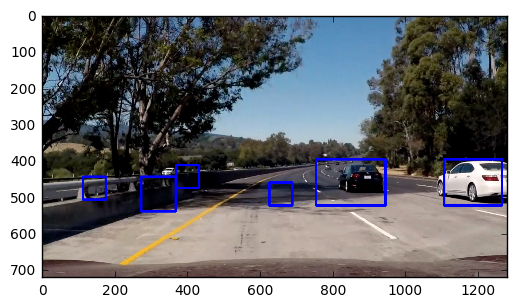

In [13]:
test_dir = "test_images/"
test_images = glob.glob(test_dir+'tes*.jpg')
for test_image in test_images:
    print()
    print("------------------------------"+test_image+"---------------------------------")
    recent_heatmaps = deque(maxlen=10)
    img = mpimg.imread(test_image)
    out_img = process_img(img, 1, True)
    plot_img(out_img, True, "Final Result")
    print()

## Test on videos

In [14]:
recent_heatmaps = deque(maxlen=10)
project_video_res = 'project_video_res.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_img)
project_video_clip.write_videofile(project_video_res, audio=False)

recent_heatmaps = deque(maxlen=10)
project_video_res = 'test_video_res.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_video_clip = clip1.fl_image(process_img)
project_video_clip.write_videofile(project_video_res, audio=False)

[MoviePy] >>>> Building video project_video_res.mp4
[MoviePy] Writing video project_video_res.mp4


100%|█████████▉| 1260/1261 [14:21<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_res.mp4 

[MoviePy] >>>> Building video test_video_res.mp4
[MoviePy] Writing video test_video_res.mp4


 97%|█████████▋| 38/39 [00:25<00:00,  1.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_res.mp4 

